In [1]:
#
# Charlie Marshak, Orinoco: Retrieving a River Delta Network with the Fast Marching Method and Python
# https://www.mdpi.com/2220-9964/9/11/658
#
# Brian E. Chapman Automated Generation of Directed Graphs from Vascular Segmentations
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4547695

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
import SimpleITK as sitk
from scipy import ndimage
import numpy as np
import networkx as nx
import skfmm
from skimage import measure, filters
from skimage.morphology import skeletonize
from skimage.segmentation import watershed

(312, 312, 301) (1.0, 1.0, 1.0)


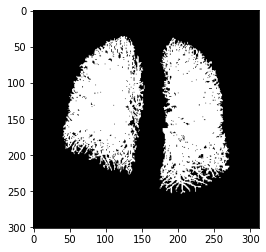

In [4]:
mask_obj = sitk.ReadImage("lung_vessels.nii.gz")
print(mask_obj.GetSize(),mask_obj.GetSpacing())
mask = sitk.GetArrayFromImage(mask_obj)

plt.imshow(np.max(mask,1),cmap='gray')

4.0


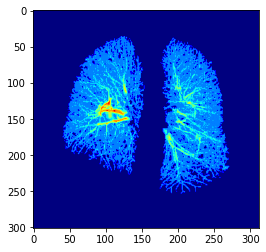

In [5]:
bsfield = ndimage.distance_transform_edt(mask)

print(np.max(bsfield))
plt.imshow(np.max(bsfield,1),cmap='jet')

1093


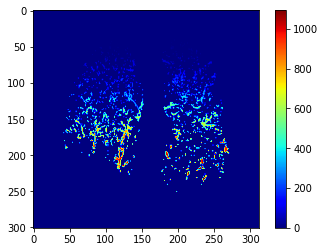

In [6]:
label = measure.label(mask)
props = measure.regionprops(label)

print(len(np.unique(label)))
plt.imshow(np.max(label,1),cmap='jet')
plt.colorbar()

th (voxels) 1000.0
[2, 3]
78538.0
4.0 1
13492854
181
16637
<class 'skimage.graph._rag.RAG'>
1.0
3.0 1
12512039
424
15105
<class 'skimage.graph._rag.RAG'>


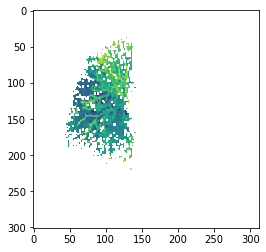

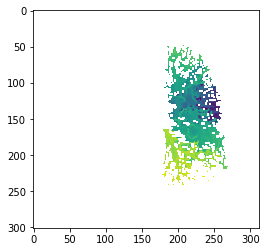

In [7]:


def get_point_seeded_field(mask,seed_ind):
    sx,sy,sz = np.unravel_index(seed_ind,mask.shape)
    mask = ~ mask.astype(bool)
    m = np.ones_like(mask)
    m[sx,sy,sz] = 0
    m = np.ma.masked_array(m, mask)
    ss_field = skfmm.distance(m,dx=1) # 
    return ss_field


th = 1000/np.prod(mask_obj.GetSpacing()) # 1cc in voxels
print('th (voxels)',th)
label_list = [x.label for x in props if x.label != 0 and x.area >= th]
print(label_list)
mydict = {}
for idx in label_list:
    item_region = label == idx
    print(props[idx].area)
    
    
    item_skeleton = skeletonize(item_region)
    item_bs = np.copy(bsfield)
    item_bs[item_skeleton==0]=0
    max_val = np.max(item_bs)
    print(max_val,np.sum(item_bs == max_val))
    item_seed = np.argmax(item_bs)
    print(np.argmax(item_bs))
    item_ssfield = get_point_seeded_field(item_region,item_seed).astype(np.int32)
    item_label = measure.label(item_ssfield)
    item_edge_map = filters.sobel(item_label)
    print(np.max(item_ssfield))
    print(len(np.unique(item_label)))
    item_rag = graph.RAG(label_image=item_label,connectivity=3)
    print(type(item_rag))
    plt.figure(idx)
    plt.imshow(np.max(item_ssfield,axis=1))
    item_rag.remove_node(0)
    mydict[idx]={'rag':item_rag,'ssfield':item_ssfield,'label':item_label}

In [8]:
for k,v in mydict.items():
    print(k,v.keys())

2 dict_keys(['rag', 'ssfield', 'label'])
3 dict_keys(['rag', 'ssfield', 'label'])


In [9]:
rag = mydict[2]['rag']

print(type(rag))
print(dir(rag))

<class 'skimage.graph._rag.RAG'>
['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_node_silent', '_adj', '_node', 'add_edge', 'add_edges_from', 'add_node', 'add_nodes_from', 'add_weighted_edges_from', 'adj', 'adjacency', 'adjlist_inner_dict_factory', 'adjlist_outer_dict_factory', 'clear', 'clear_edges', 'copy', 'degree', 'edge_attr_dict_factory', 'edge_subgraph', 'edges', 'fresh_copy', 'get_edge_data', 'graph', 'graph_attr_dict_factory', 'has_edge', 'has_node', 'is_directed', 'is_multigraph', 'max_id', 'merge_nodes', 'name', 'nbunch_iter', 'neighbors', 'next_id', 'node_attr_dict_factory', 'node_dict_factory', 'nodes', 'number_of_edges', 

In [10]:
print(rag.number_of_edges(),rag.number_of_nodes())

37899 16636


(16636, 3)
(37899, 2, 3)
(15104, 3)
(35619, 2, 3)


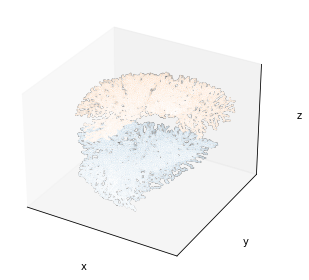

In [52]:
from mpl_toolkits.mplot3d import Axes3D


# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for k,v in mydict.items():
    item_rag = v['rag']
    item_label = v['label']

    item_props = measure.regionprops(item_label)
    for (n, data), region in zip(item_rag.nodes(data=True), item_props):
        data['pos'] = tuple(map(int, region['centroid'] ))

    # Extract node and edge positions from the layout
    item_dict = {k:v for k,v in item_rag.nodes(data=True)}
    node_xyz = np.array([item_dict[v]['pos'] for v in sorted(item_rag)])
    print(node_xyz.shape)
    edge_xyz = np.array([(item_dict[u]['pos'],item_dict[v]['pos']) for u, v in item_rag.edges()])
    print(edge_xyz.shape)

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, s=1, ec="w")

    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()


In [ ]:
mytmp = np.zeros_like(mask).astype(np.uint8) # use less colors

for k,v in mydict.items():
    item_rag = v['rag']
    item_label = v['label']
    mytmp = v['label']
    item_props = measure.regionprops(item_label)
    for (n, data), r in zip(item_rag.nodes(data=True), item_props):
        edge_list = nx.edges(item_rag,[n])
        is_intersection = True if len(edge_list) >= 3 else False
        value = 2 if is_intersection else 1
        mytmp[item_label==r.label]=value

In [ ]:
mytmp_obj = sitk.GetImageFromArray(mytmp)
mytmp_obj.CopyInformation(mask_obj)
sitk.WriteImage(mytmp_obj,'mytmp.nii.gz')


(312, 312, 301) (1.0, 1.0, 1.0)


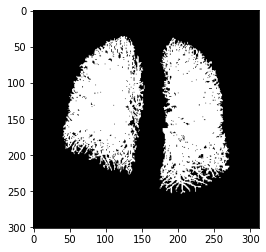

In [45]:
mask_obj = sitk.ReadImage("lung_vessels.nii.gz")
print(mask_obj.GetSize(),mask_obj.GetSpacing())
mask = sitk.GetArrayFromImage(mask_obj)
plt.imshow(np.max(mask,1),cmap='gray')


skeletonize...
skeleton voxel count: 37683
intersection...
8131 8130
watershed...
8131


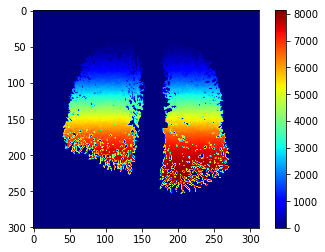

In [46]:
print('skeletonize...')
skeleton = skeletonize(mask)
skeleton = skeleton.astype(np.int32)
print(f'skeleton voxel count: {np.sum(skeleton)}')

print('intersection...')
weights = np.ones((3,3,3))
intersection = ndimage.convolve(skeleton,weights) > 3

branch = np.copy(skeleton).astype(np.int32)
branch[intersection==1]=0
label = measure.label(branch)
props = measure.regionprops(label)

print(len(np.unique(label)),len(props))

print('watershed...')
ws_branch = watershed(mask*-1, label, mask=mask>0)
ws_branch = ws_branch.astype(np.int32)

print(len(np.unique(ws_branch)))
plt.imshow(np.max(ws_branch,1),cmap='jet')
plt.colorbar()



In [47]:

mytmp = np.zeros_like(mask).astype(np.uint8) # use less colors

# why bother with RAG if you already have this info?
if False:
    rag = graph.RAG(label_image=ws_branch,connectivity=3)
    rag.remove_node(0)
    print(type(rag))

    for (n, data), r in zip(rag.nodes(data=True), props):
        edge_list = nx.edges(rag,[n])
        is_intersection = True if len(edge_list) >= 3 else False
        value = 2 if is_intersection else 1
        mytmp[ws_branch==r.label]=value

mytmp[ws_branch!=0]=ws_branch[ws_branch!=0]+1
mytmp[intersection==1]=1

mytmp_obj = sitk.GetImageFromArray(mytmp)
mytmp_obj.CopyInformation(mask_obj)
sitk.WriteImage(mytmp_obj,'mytmp.nii.gz')